In [16]:
# Utils
import time
import cv2
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
from keras.metrics import Precision, Recall

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Dropout, Lambda, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import model_from_json

In [17]:
def extractImages(datapoints):
  # Reshape sequences to images  
  width, height = 48, 48

  #getting features for training
  X = []
  for sequence in datapoints:
    pixels = [int(p) for p in sequence.split(' ')]
    pixels = np.asarray(pixels).reshape(width, height)
    X.append(pixels.astype('float32'))

  X = np.asarray(X)
  X = np.expand_dims(X, -1)
  return X

def load_FER13():
  # load the data from Google Drive into a Pandas DataFrame

  data = pd.read_csv("C:\\Users\\arnab\\Downloads\\fer2013.csv\\fer2013.csv")


  X = data.loc[:, 'pixels']
  Y = data.loc[:, 'emotion_label']

  # Split dataset based on 'Usage' column
  x_test = X.loc[data['Usage'] == 'PublicTest'].values
  y_test = Y.loc[data['Usage'] == 'PublicTest'].values

  x_train_full = X.loc[data['Usage'] == 'Training'].values
  y_train_full = Y.loc[data['Usage'] == 'Training'].values

  # Further split the training data into 60% test and 40% validation
  x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.4, random_state=42)

    
  #getting labels for training
  y_train = pd.get_dummies(y_train).values
  y_val = pd.get_dummies(y_val).values
  y_test = pd.get_dummies(y_test).values

  # Reshape to image
  x_train = extractImages(x_train)
  x_val = extractImages(x_val)
  x_test = extractImages(x_test)

  # Standardization
  train_mean = np.mean(x_train, axis=0)
  train_std = np.std(x_train, axis=0)

  x_train = (x_train - train_mean) / train_std
  x_val = (x_val - train_mean) / train_std
  x_test = (x_test - train_mean) / train_std


  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

  

(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_FER13()

In [18]:
# Just in case we need it
def PermaDropout(rate): # insures usage of dropout in evaluation (tf disables normal dropout in testing by default)
    return Lambda(lambda x: tf.keras.backend.dropout(x, level=rate))

def buildModel(activation_function='relu', padding='same', kernel_sizes=[(3,3)], filters=(8, 12), 
                pooling_kernels = [(2,2)], dilation_rate = (1,1), strides = (1,1), 
                input_shape=(48, 48, 1), dense_units=[], output_classes=7, dropout_rate=0):
    """
        function that builds a CNN model with an architecture specified in its parameters.
    
    """
    assert len(kernel_sizes) == len(filters), "Please make sure you define a kernel size for every ConvLayer"
    #input_shape: 48 x 48 pixels with 1 color channel?

    model = Sequential() # using a sequential architecture
    # Feature Extractor (CNN part)
    for i in range(len(filters)):    
        if i == 0:
            # input layer
            model.add(Conv2D(
                activation=activation_function,
                filters=filters[i],
                kernel_size=kernel_sizes[i],
                padding=padding,
                strides=strides,
                data_format='channels_last',
                dilation_rate=dilation_rate, # dilation only used in first layer for now
                input_shape=input_shape))
        else:
          # Hidden Layers
          model.add(Conv2D(
              activation=activation_function,
              filters=filters[i],
              kernel_size=kernel_sizes[i],
              padding=padding,
              strides=strides
              )
          )
          
          model.add(BatchNormalization())

        if i < len(pooling_kernels):
            model.add(MaxPooling2D(pooling_kernels[i]))
    
        if dropout_rate is not None and dropout_rate != 0:
            model.add(PermaDropout(dropout_rate))

    # ANN part (Classifier)
    model.add(Flatten())
    for units in dense_units:
        model.add(Dense(units, activation=activation_function))

        if dropout_rate is not None and dropout_rate != 0:
            model.add(PermaDropout(dropout_rate))
    # ouput prediction of 7 class probabilities
    model.add(Dense(output_classes, activation='softmax'))
    return model

In [19]:
def compileModel(model, initial_lr, lr_decay):

    # Learning rate handling
    if lr_decay == 1:
        lr_schedule = initial_lr    
    else:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=16, decay_rate=lr_decay, staircase=True)
    opt = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [20]:
def runtest(model, epochs, batchsize, model_name=''):
    # unpack data
    # just using global variables...
    # (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_FER13()

    start_time = time.time()
    callbacks_list = []#[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)]

    callbacks_list.append(
    tf.keras.callbacks.ModelCheckpoint(
            'checkpoint.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            save_freq='epoch', verbose=0
        )
    )
        
    print("train_data.shape=", len(x_train), len(y_train))
    print("batchsize=", batchsize)
    print("epochs=", epochs)

    # history = model.fit(x=x_train, y=y_train,
    #                     batch_size=batchsize,
    #                     epochs=epochs, # Iterations are epochs <- better for plotting... smaller steps
    #                     validation_data=(x_val, y_val),
    #                     callbacks=callbacks_list,
    #                     shuffle=True)
    
    history = model.fit(x=x_train, y=y_train,
                        batch_size=batchsize,
                        epochs=epochs, # Iterations are epochs <- better for plotting... smaller steps
                        validation_data=(x_val, y_val),
                        callbacks=callbacks_list,
                        shuffle=True)

    print("Evaluate on test data")
    model.evaluate(x=x_test, y=y_test, batch_size=batchsize)

    print("--- %s seconds ---" % (time.time() - start_time))

    np.save(model_name +'_history.npy',history.history)
    model.save(model_name + '.h5') # around 395 mb...

    return history

In [21]:
### HYPERPARAMETERS
learning_rate = 1e-4
lr_decay = 1
L2_reg_rate = 0
batchsize = 64
epochs = 40
initial = 64
layers = 4

test_set = [(2, 2)] 
histories = []

for dilationrate in test_set:
    kernelsizes = [(3, 3) for i in range(layers)]
    pooling = [(2, 2) for i in range(3)]
    
    filterunits = [initial * pow(2, i) for i in range(len(kernelsizes))]
    dense = [filterunits[-1], filterunits[-2]] # same as last conv filtercount

    model_name = 'Output'

    model = buildModel(activation_function='relu', padding='same', kernel_sizes=kernelsizes,
                       filters=filterunits, pooling_kernels=pooling, dilation_rate=dilationrate,
                       strides=(1, 1), input_shape=(48, 48, 1), dense_units=dense, output_classes=7,
                       dropout_rate=0.25)

    model = compileModel(model, learning_rate, lr_decay)
    model.summary()
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=96)
from IPython.display import Image

Image("model.png")

from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(
    model, 
    to_file="model_tree.png", 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir="TB",  # 'TB' for a top-down tree, 'LR' for left-to-right
    dpi=96
)

Image("model_tree.png")
    
    # Train
histories.append(runtest(model, epochs, batchsize, model_name))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_12 (Lambda)              │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_14 (Lambda)              │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_15 (Lambda)              │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_16 (Lambda)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_17 (Lambda)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,124,231 (42.44 MB)

 Trainable params: 11,122,439 (42.43 MB)

 Non-trainable params: 1,792 (7.00 KB)

train_data.shape= 17225 17225
batchsize= 64
epochs= 40
Epoch 1/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2419 - loss: 2.0712

270/270 ━━━━━━━━━━━━━━━━━━━━ 132s 481ms/step - accuracy: 0.2420 - loss: 2.0706 - val_accuracy: 0.2234 - val_loss: 2.6135
Epoch 2/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.3260 - loss: 1.7069

270/270 ━━━━━━━━━━━━━━━━━━━━ 131s 485ms/step - accuracy: 0.3260 - loss: 1.7068 - val_accuracy: 0.3322 - val_loss: 1.7122
Epoch 3/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.3585 - loss: 1.6446

270/270 ━━━━━━━━━━━━━━━━━━━━ 127s 470ms/step - accuracy: 0.3585 - loss: 1.6446 - val_accuracy: 0.3644 - val_loss: 1.6242
Epoch 4/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.3791 - loss: 1.5977

270/270 ━━━━━━━━━━━━━━━━━━━━ 124s 458ms/step - accuracy: 0.3791 - loss: 1.5976 - val_accuracy: 0.3726 - val_loss: 1.6080
Epoch 5/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.4013 - loss: 1.5285

270/270 ━━━━━━━━━━━━━━━━━━━━ 129s 478ms/step - accuracy: 0.4013 - loss: 1.5285 - val_accuracy: 0.3946 - val_loss: 1.5594
Epoch 6/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.4279 - loss: 1.4803

270/270 ━━━━━━━━━━━━━━━━━━━━ 137s 509ms/step - accuracy: 0.4279 - loss: 1.4803 - val_accuracy: 0.4073 - val_loss: 1.5333
Epoch 7/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4384 - loss: 1.4418

270/270 ━━━━━━━━━━━━━━━━━━━━ 118s 436ms/step - accuracy: 0.4384 - loss: 1.4418 - val_accuracy: 0.4188 - val_loss: 1.5085
Epoch 8/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4576 - loss: 1.3932

270/270 ━━━━━━━━━━━━━━━━━━━━ 117s 433ms/step - accuracy: 0.4576 - loss: 1.3932 - val_accuracy: 0.4350 - val_loss: 1.4790
Epoch 9/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 115s 426ms/step - accuracy: 0.4859 - loss: 1.3344 - val_accuracy: 0.4326 - val_loss: 1.4977
Epoch 10/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.5063 - loss: 1.2990

270/270 ━━━━━━━━━━━━━━━━━━━━ 118s 436ms/step - accuracy: 0.5063 - loss: 1.2990 - val_accuracy: 0.4397 - val_loss: 1.4528
Epoch 11/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.5259 - loss: 1.2523

270/270 ━━━━━━━━━━━━━━━━━━━━ 118s 437ms/step - accuracy: 0.5259 - loss: 1.2523 - val_accuracy: 0.4552 - val_loss: 1.4430
Epoch 12/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5362 - loss: 1.2050

270/270 ━━━━━━━━━━━━━━━━━━━━ 117s 434ms/step - accuracy: 0.5362 - loss: 1.2050 - val_accuracy: 0.4580 - val_loss: 1.4320
Epoch 13/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 113s 420ms/step - accuracy: 0.5716 - loss: 1.1353 - val_accuracy: 0.4628 - val_loss: 1.4328
Epoch 14/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 114s 424ms/step - accuracy: 0.5895 - loss: 1.0788 - val_accuracy: 0.4697 - val_loss: 1.4367
Epoch 15/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 114s 422ms/step - accuracy: 0.6119 - loss: 1.0290 - val_accuracy: 0.4862 - val_loss: 1.4425
Epoch 16/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 114s 421ms/step - accuracy: 0.6345 - loss: 0.9692 - val_accuracy: 0.4820 - val_loss: 1.4437
Epoch 17/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 117s 433ms/step - accuracy: 0.6716 - loss: 0.8873 - val_accuracy: 0.4822 - val_loss: 1.4661
Epoch 18/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 116s 428ms/step - accuracy: 0.6976 - loss: 0.8169 - val_accuracy: 0.4847 - val_loss: 1.5022
Epoch 19/40
270/270 ━━━━━━━━━━━━━━━━━━━━ 114s 423ms/step - accuracy: 0.7239 - los

--- 4836.943324327469 seconds ---


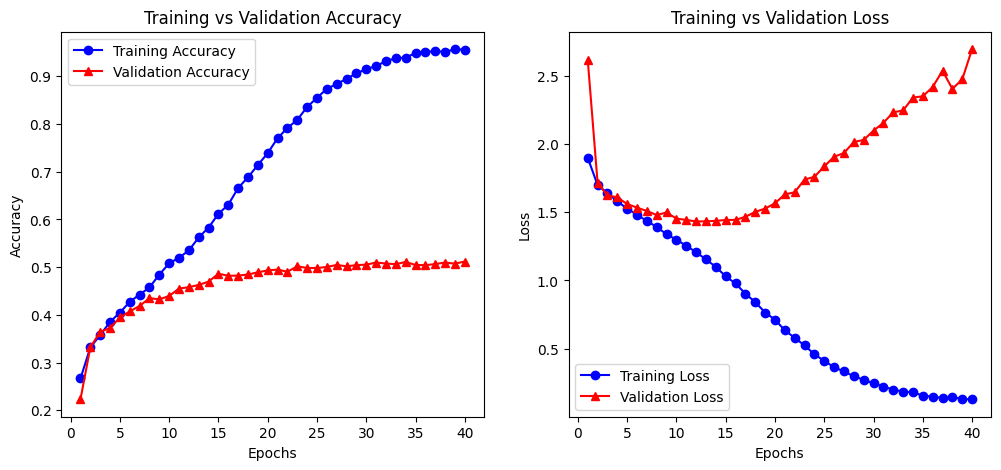

In [25]:
import matplotlib.pyplot as plt

# Function to plot Accuracy & Loss Graphs
def plot_training_history(history):
    # Extract values from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()

# Call the function after training
plot_training_history(histories[-1])


In [26]:
from sklearn.metrics import classification_report
import pandas as pd

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class labels

# Compute Precision, Recall, and F1-Score with output_dict=True
report_dict = classification_report(y_true, y_pred_classes, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], output_dict=True)

# Format the values to 4 decimal places
formatted_report = {key: {metric: f"{value:.4f}" for metric, value in metrics.items()} 
                    if isinstance(metrics, dict) else f"{metrics:.4f}" 
                    for key, metrics in report_dict.items()}

# Convert to a DataFrame for better display
report_df = pd.DataFrame(formatted_report).transpose()

print("Classification Report:\n")
print(report_df)


113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step
Classification Report:

             precision  recall f1-score    support
angry           0.3983  0.4026   0.4004   467.0000
disgust         0.4634  0.3393   0.3918    56.0000
fear            0.4175  0.3569   0.3848   496.0000
happy           0.6884  0.7330   0.7100   895.0000
neutral         0.4038  0.3920   0.3978   653.0000
sad             0.7507  0.6458   0.6943   415.0000
surprise        0.4167  0.4860   0.4487   607.0000
accuracy        0.5180  0.5180   0.5180     0.5180
macro avg       0.5055  0.4794   0.4897  3589.0000
weighted avg    0.5191  0.5180   0.5170  3589.0000


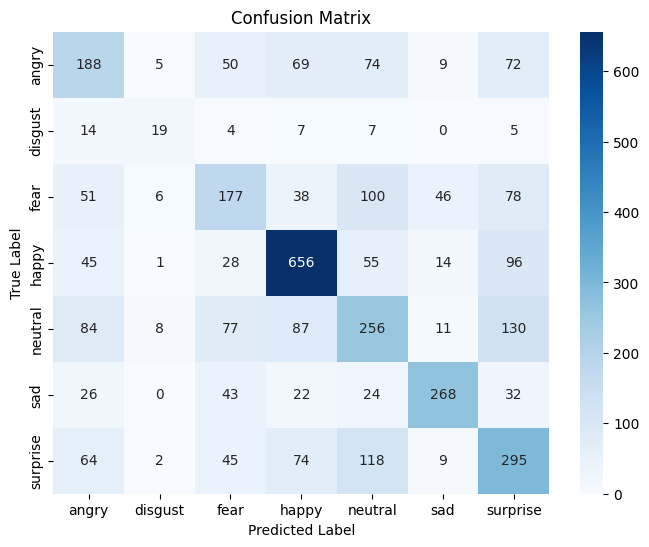

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
            yticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
